<a href="https://colab.research.google.com/github/YeongChaeYun7/OpenCV/blob/main/Durian_OCR_model_comparison_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# < 서류 이미지에서 텍스트 추출 OCR 프로젝트 >

### 소속
  한국폴리텍대학교 스마트금융과 7기

### 팀원
  윤영채, 이지은

### 목표
  다양한 형식의 이미지 파일에서 특정 텍스트 정보를 추출하는 시스템 개발

### 데이터
  (주)두리안정보기술사의 납품/검수 확인서(PDF, jpg) 및 제품정보(xlsx)

### 목차
1. 필요 패키지 및 라이브러리 연동
2. 원본 데이터 확인
3. PDF 텍스트 추출 라이브러리 비교 및 적용
4. 데이터 전처리
5. OCR 라이브러리 비교 및 적용
6. 추출한 텍스트 데이터 구조화 및 저장
7. 추출한 텍스트 데이터 유사도 검증

# 필요 패키지 및 라이브러리 연동

In [ ]:
!sudo apt install tesseract-ocr
!sudo apt-get install tesseract-ocr-kor
!pip -qqq install PyPDF2
!pip -qqq install pdfminer.six
!pip -qqq install pdfplumber
!pip -qqq install pytesseract
!pip -qqq install PyMuPDF # pymupdf와 같은 라이브러리 최신 버전
!pip -qqq install easyocr
!pip -qqq install keras-ocr
!pip -qqq install --upgrade google-api-python-client # 2.133.0
!pip -qqq install --upgrade google-cloud-vision # 3.7.2
!pip -qqq install fuzzywuzzy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,471 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import PyPDF2
import re
import fitz  # PyMuPDF
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer
import pdfplumber
from PIL import Image
import pytesseract
import requests
import easyocr
import keras_ocr
from google.cloud import vision
from fuzzywuzzy import fuzz
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from difflib import SequenceMatcher
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/Colab Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


# 원본 데이터 확인

In [ ]:
def findTargetPaths(dataInputPath):
    '''
    경로 내에서 특정 확장자를 가지는 파일의 경로를 추출하는 함수
    '''
    paths = [] # 타겟 파일의 전체 경로를 저장할 리스트
    extension_list=['png', 'jpeg', 'jpg', 'pdf']# 타겟 파일의 확장자

    try:
        for dirpath, dirnames, filenames in os.walk(dataInputPath): # 지정 경로 내의 하위 디렉토리 전체 순회
            for filename in filenames:
                if 'table' in filename:# 테이블 이미지 제외, 원본 이미지만 호출
                  raise
                if filename.split('.')[-1] in extension_list:
                    paths.append(os.path.join(dirpath, filename)) # 파일의 전체 경로를 문자열으로 paths list에 저장
                else:
                  pass
    except Exception as e:
                print(e)
    return paths

In [ ]:
# 경로 내의 타겟 파일(png, jpeg, jpg, pdf) 확인
dataInputPath = "./durian_dataset"
paths = findTargetPaths(dataInputPath)
# paths

No active exception to reraise


In [ ]:
# 이미지 호출 함수
def load_image(path, extension_list=['png', 'jpeg', 'jpg', 'pdf']):
  '''
  파일 경로를 입력받아 numpy.ndarray 타입의 이미지 변수로 변경해주는 함수
  '''
  extension = path.split('.')[-1]
  filename = path.split('/')[-1]  # Exception 표시용

  if extension not in extension_list:
    raise ValueError(f'Unsupported extension: {filename}')

  # png, jpeg, jpg 확장자 파일일 경우
  if extension in ['png', 'jpeg', 'jpg'] :
    flag = cv2.IMREAD_COLOR
    img = cv2.imread(path, flag)

  # pdf 확장자 파일일 경우
  elif extension == 'pdf':
    pdf_document = fitz.open(path)
    page = pdf_document.load_page(0)  # 첫 번째 페이지만 호출 설정
    pix = page.get_pixmap()
    img = cv2.imdecode(np.frombuffer(pix.tobytes(), dtype=np.uint8), cv2.IMREAD_GRAYSCALE) # 흑백이미지로 호출하여 채널 1개만 사용
  else:
    raise ValueError(f'Unsupported extension: {filename}')

  if img is None:
    raise Exception(f'Image call failed: {filename}')

  return img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
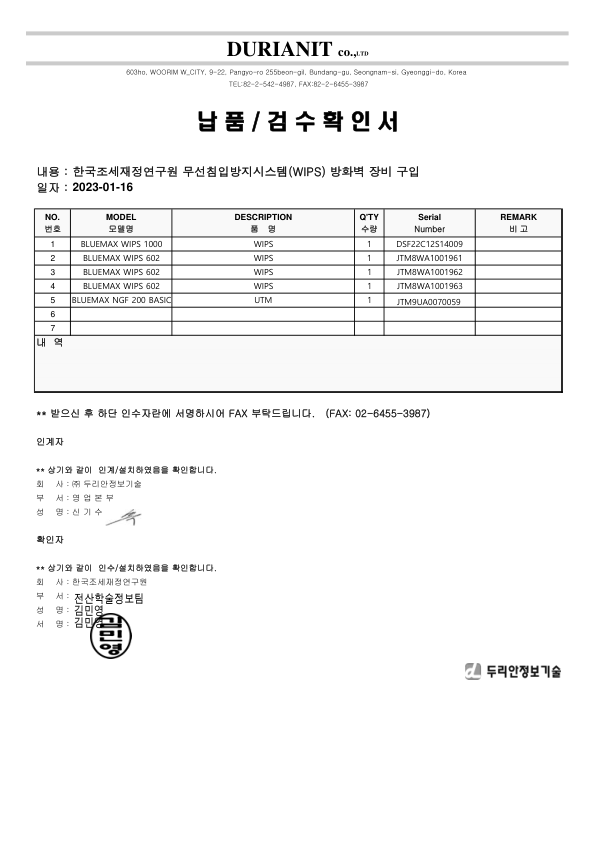

In [ ]:
load_image(paths[0])

# PDF 텍스트 추출 라이브러리 비교 및 적용
- PyPDF2

  PDF 병합, 분할, 메타데이터 수정 가능  
  텍스트 추출 정확도 낮음  

- PyMuPDF (fitz)

  빠른 속도, PDF 렌더링 기능 포함  
  텍스트 추출 정확도 낮음, 복잡한 레이아웃 처리 어려움  

- pdfminer.six

  PDF 구조 분석, 텍스트 레이아웃 보존  
  속도 느림, 이미지 기반 PDF 처리 어려움

- pdfplumber

  텍스트 및 이미지 추출 가능, 다양한 PDF 포맷 지원  
  텍스트 추출 정확도 낮음, 이미지 기반 PDF 처리 어려움  
  

##PyPDF2

In [ ]:
def extract_text_pypdf2(path):
    with open(path, 'rb') as file:

        reader = PyPDF2.PdfReader(file)
        text_list = []

        for page_num in range(len(reader.pages)):
            page = reader.pages[page_num]
            text = page.extract_text()
            text_list.append(text.split('\n'))
    return text_list

In [ ]:
path = paths[0]
print(extract_text_pypdf2(path))

[['내용 : 한국조세재정연구원 무선침입방지시스템(WIPS) 방화벽 장비 구입 ', '일자 : 2023-01-16', "NO. MODEL DESCRIPTION Q'TY Serial REMARK", '번호 모델명 품    명 수량 Number 비 고', '1 BLUEMAX WIPS 1000 WIPS 1', 'JTM9UA00700592 BLUEMAX WIPS 602 WIPS 1 JTM8WA1001961', '3 BLUEMAX WIPS 602 WIPS 1 JTM8WA1001962', '4 BLUEMAX WIPS 602 WIPS 1 JTM8WA1001963', '5BLUEMAX NGF 200 BASIC UTM 1DSF22C12S14009', '6', '7', '내  역', '** 받으신 후 하단 인수자란에 서명하시어 FAX 부탁드립니다.   (FAX: 02-6455-3987)', '인계자', '** 상기와 같이  인계/설치하였음을 확인합니다.', '회    사 : ㈜ 두리안정보기술', '부    서 : 영 업 본 부', '성    명 : 신 기 수', '확인자', '** 상기와 같이  인수/설치하였음을 확인합니다.', '회    사 : 한국조세재정연구원', '부    서 : ', '성    명 :', '서    명 :DURIANIT co., LTD', '603ho, WOORIM W_CITY, 9-22, Pangyo-ro 255beon-gil, Bundang-gu, Seongnam-si, Gyeonggi-do, Korea ', ' TEL:82-2-542-4987, FAX:82-2-6455-3987', '납 품 / 검 수 확 인 서', 'Àü', '»ê', 'ÇÐ', '¼ú', 'Á¤', 'º¸', 'ÆÀ', '±è', '¹Î', '¿µ', '±è', '¹Î', '¿µ', '']]


/usr/local/lib/python3.10/dist-packages/PyPDF2/_cmap.py:142: PdfReadWarning: Advanced encoding /KSCms-UHC-H not implemented yet
  warnings.warn(


In [ ]:
# plt.figure(figsize=(20, 20))
# plt.imshow(cv2.cvtColor(load_image(path), cv2.IMREAD_GRAYSCALE))
# plt.title('org')
# plt.axis('off')
# plt.show()

##PyMuPDF (fitz)

In [ ]:
def extract_text_pymupdf(path):
    doc = fitz.open(path)
    text_list = []
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        blocks = page.get_text("blocks")
        page_text = [block[4] for block in blocks]
        text_list.append(page_text)
    return text_list

In [ ]:
print(extract_text_pymupdf(path))

[['내용 : 한국조세재정연구원 무선침입방지시스템(WIPS) 방화벽 장비 구입 \n일자 : 2023-01-16\n', "NO.\nMODEL\nDESCRIPTION\nQ'TY\nSerial\nREMARK\n", '번호\n모델명\n품    명\n수량\nNumber\n비 고\n', '1\nBLUEMAX WIPS 1000\nWIPS\n1\n', 'JTM9UA0070059\n', '2\nBLUEMAX WIPS 602\nWIPS\n1\nJTM8WA1001961\n', '3\nBLUEMAX WIPS 602\nWIPS\n1\nJTM8WA1001962\n', '4\nBLUEMAX WIPS 602\nWIPS\n1\nJTM8WA1001963\n', '5\nBLUEMAX NGF 200 BASIC\nUTM\n1\n', 'DSF22C12S14009\n', '6\n', '7\n', '내  역\n', '** 받으신 후 하단 인수자란에 서명하시어 FAX 부탁드립니다.   (FAX: 02-6455-3987)\n', '인계자\n', '** 상기와 같이  인계/설치하였음을 확인합니다.\n', '회    사 : ㈜ 두리안정보기술\n', '부    서 : 영 업 본 부\n', '성    명 : 신 기 수\n', '확인자\n', '** 상기와 같이  인수/설치하였음을 확인합니다.\n', '회    사 : 한국조세재정연구원\n', '부    서 : \n', '성    명 :\n', '서    명 :\n', 'DURIANIT co.,LTD\n', '603ho, WOORIM W_CITY, 9-22, Pangyo-ro 255beon-gil, Bundang-gu, Seongnam-si, Gyeonggi-do, Korea \n', ' TEL:82-2-542-4987, FAX:82-2-6455-3987\n', '납 품 / 검 수 확 인 서\n', '전산학술정보팀\n김민영\n김민영\n']]


##pdfminer.six

In [ ]:
def extract_text_pdfminer(path):
    text_list = []
    for page_layout in extract_pages(path):
        page_text = []
        for element in page_layout:
            if isinstance(element, LTTextContainer):
                page_text.append(element.get_text())
        text_list.append(page_text)
    return text_list

In [ ]:
print(extract_text_pdfminer(path))

[['DURIANIT co.,LTD\n', '603ho, WOORIM W_CITY, 9-22, Pangyo-ro 255beon-gil, Bundang-gu, Seongnam-si, Gyeonggi-do, Korea \n', ' TEL:82-2-542-4987, FAX:82-2-6455-3987\n', '납 품 / 검 수 확 인 서\n', '내용 : 한국조세재정연구원 무선침입방지시스템(WIPS) 방화벽 장비 구입 \n일자 : 2023-01-16\n', 'NO.\n번호\n', 'MODEL\n모델명\n', 'DESCRIPTION\n품    명\n', "Q'TY\n수량\n", 'Serial\nNumber\n', 'REMARK\n비 고\n', 'BLUEMAX WIPS 1000\n', 'BLUEMAX WIPS 602\n', 'BLUEMAX WIPS 602\n', 'BLUEMAX WIPS 602\n', 'BLUEMAX NGF 200 BASIC\n', '1\n', '2\n', '3\n', '4\n', '5\n', '6\n', '7\n내  역\n', 'WIPS\n', 'WIPS\n', 'WIPS\n', 'WIPS\n', 'UTM\n', '1\n', '1\n', '1\n', '1\n', '1\n', 'DSF22C12S14009\n', 'JTM8WA1001961\n', 'JTM8WA1001962\n', 'JTM8WA1001963\n', 'JTM9UA0070059\n', '** 받으신 후 하단 인수자란에 서명하시어 FAX 부탁드립니다.   (FAX: 02-6455-3987)\n', '인계자\n', '** 상기와 같이  인계/설치하였음을 확인합니다.\n', '회    사 : ㈜ 두리안정보기술\n', '부    서 : 영 업 본 부\n', '성    명 : 신 기 수\n', '확인자\n', '** 상기와 같이  인수/설치하였음을 확인합니다.\n', '회    사 : 한국조세재정연구원\n', '부    서 : \n', '성    명 :\n', '서    명 :\n', '전산학술정보팀\n

##pdfplumber

In [ ]:
def extract_text_pdfplumber(path):
    text_list = []
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                text_list.append(page_text.split('\n'))
    return text_list

In [ ]:
print(extract_text_pdfplumber(path))

[['DURIANIT', 'co.,', 'LTD', '603ho, WOORIM W_CITY, 9-22, Pangyo-ro 255beon-gil, Bundang-gu, Seongnam-si, Gyeonggi-do, Korea', 'TEL:82-2-542-4987, FAX:82-2-6455-3987', '납 품 / 검 수 확 인 서', '내용 : 한국조세재정연구원 무선침입방지시스템(WIPS) 방화벽 장비 구입', '일자 : 2023-01-16', "NO. MODEL DESCRIPTION Q'TY Serial REMARK", '번호 모델명 품 명 수량 Number 비 고', '1 BLUEMAX WIPS 1000 WIPS 1 DSF22C12S14009', '2 BLUEMAX WIPS 602 WIPS 1 JTM8WA1001961', '3 BLUEMAX WIPS 602 WIPS 1 JTM8WA1001962', '4 BLUEMAX WIPS 602 WIPS 1 JTM8WA1001963', '5 BLUEMAX NGF 200 BASIC UTM 1 JTM9UA0070059', '6', '7', '내 역', '** 받으신 후 하단 인수자란에 서명하시어 FAX 부탁드립니다. (FAX: 02-6455-3987)', '인계자', '** 상기와 같이 인계/설치하였음을 확인합니다.', '회 사 : ㈜ 두리안정보기술', '부 서 :영 업 본 부', '성 명 : 신 기 수', '확인자', '** 상기와 같이 인수/설치하였음을 확인합니다.', '회 사 : 한국조세재정연구원', '부 서 : 전산학술정보팀', '성 명 : 김민영', '서 명 : 김민영']]


PDF OCR 라이브러리 적용 결과, 이미지 품질에 따라 인식 차이가 심함  
요구하는 이미지 수준 이상의 데이터만 적용 가능  
PDF 형식의 파일만 적용 가능해서 확장하는데 한계가 있음

# 데이터 전처리

이미지 데이터의 평균 수준을 상향시키고자 데이터 전처리 적용  
파일 이미지가 대상이라 노이즈를 줄이고 선명도를 최대한 올리고자 함  
엣지 검출을 통해 목표 텍스트가 포함된 테이블 영역만 추출

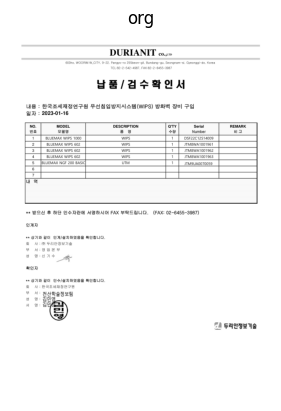

In [ ]:
# 원본 이미지 확인

path = paths[0] # PDF 파일
# path = paths[5] # jpg 파일

image = load_image(path)

# plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE))
plt.title('org')
plt.axis('off')
plt.show()

In [ ]:
def sharpen_image(image):
    '''
    이미지의 잡음을 줄이고 선명하게 만드는 함수
    '''
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 가우시안 블러 처리 (잡음처리. 이미 흑백 문서라 약하게 설정)
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)

    # 중앙값 블러 처리(잡음처리22)
    median_blurred_image = cv2.medianBlur(blurred_image, 5)

    # 선명화 효과
    sharpened_image = cv2.addWeighted(image, 2.0, median_blurred_image, -1.0, 0)

    # CLAHE 적용. 대비도 높임
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(sharpened_image)

    return enhanced_image

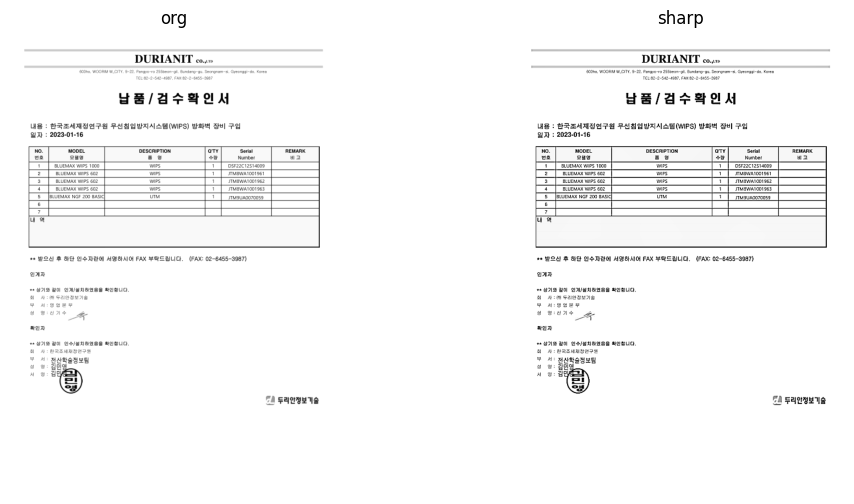

In [ ]:
img = image.copy()
sharpened_img = sharpen_image(img)

# 결과 비교
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('org')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('sharp')
plt.imshow(sharpened_img, cmap='gray')
plt.axis('off')

# plt.figure(figsize=(20, 20))
# plt.imshow(cv2.cvtColor(sharpened_img, cv2.IMREAD_GRAYSCALE))
# plt.title('sharp')
# plt.axis('off')

plt.show()

In [ ]:
# 이미지 선명화 작업 후에 적용해야 정확한 영역 추출 가능
def extract_table(img):
    '''
    이미지에서 테이블 영역만 추출하는 함수
    '''
    # 이미지 이진화
    _, binary = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV) # 이진화 처리된 이미지는 활용하지 않아 '_' 처리

    # 수평선과 수직선 검출
    kernel_h = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
    kernel_v = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))

    detect_horizontal = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_h)
    detect_vertical = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_v)

    # 수평선과 수직선 결합
    mask = detect_horizontal + detect_vertical

    # 테이블 검출
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 테이블 추출
    table_cnt = None
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 100 and h > 10:  # 테이블 크기에 따라 조정
            table_cnt = cnt
            break

    if table_cnt is not None:
        x, y, w, h = cv2.boundingRect(table_cnt)
        res = img[y:y+h, x:x+w]

    else:
        print("Table area not found")
    return res

array([[ 24,   3,   3, ...,  38,  66, 255],
       [  3, 140, 152, ...,   2,   2, 255],
       [  3, 255, 255, ...,   2,   2, 255],
       ...,
       [  3,   3,   3, ...,   3,   3, 255],
       [  3,   3,   3, ...,   3,   3, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
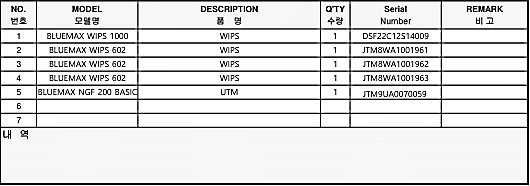

In [ ]:
img = sharpened_img.copy()
extract_table(img)

In [ ]:
# # 테이블 추출 이미지 저장

# # 테이블 이미지 저장 폴더 생성
# table_image_path = os.path.join('/'.join(path.split('/')[:-1]), "table_image")
# if not os.path.exists(table_image_path):
#     os.makedirs(table_image_path)

# # 저장
# for i in range(len(paths)):
#     path = paths[i]
#     file_name = path.split('/')[-1].split('.')[-2] + "_table." + path.split('.')[-1]
#     file_save_path = table_image_path + "/" + file_name

#     img = load_image(path)
#     sharpen_img = sharpen_image(img)
#     table_img = extract_table(sharpen_img)

#     table_img = Image.fromarray(table_img)
#     table_img.save(file_save_path)
#     print(f"Saved {file_save_path}")

In [ ]:
def show_table(path):
  '''
  이미지의 호출부터 전처리, 테이블 영역 추출을 적용하는 함수
  '''
  img = load_image(path)
  sharpen_img = sharpen_image(img)
  table_img = extract_table(sharpen_img)
  return table_img

array([[ 24,   3,   3, ...,  38,  66, 255],
       [  3, 140, 152, ...,   2,   2, 255],
       [  3, 255, 255, ...,   2,   2, 255],
       ...,
       [  3,   3,   3, ...,   3,   3, 255],
       [  3,   3,   3, ...,   3,   3, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
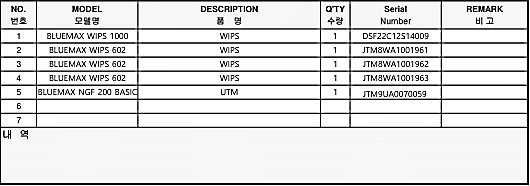

In [ ]:
path = paths[0]
show_table(path)

# OCR 라이브러리 비교 및 적용

- pytesseract  
  Tesseract OCR 엔진을 Python에서 사용할 수 있게 해주는 오픈소스 라이브러리  
  다양한 언어와 글꼴 인식 가능

- EasyOCR  
  PyTorch 기반의 오픈 소스 OCR 라이브러리  
  80개 이상의 언어 지원 가능  
  언어에 따른 인식률 차이가 있음

- Keras-OCR  
  Keras 및 TensorFlow를 기반으로 하는 오픈 소스 OCR 라이브러리  
  커스터마이징이 용이
  모델 실행 속도가 느림  

- Google Vision AI    
  Google의 클라우드 기반 OCR 서비스로, 이미지 내 텍스트 인식뿐만 아니라 다양한 이미지 분석 기능 제공  
  클라우드 기반 서비스로, Google의 서버에서 이미지 분석을 수행하므로 인터넷 연결 필요  
  높은 정확도를 보이지만 일정 횟수 이상은 유료 서비스로 전환됨 (월 1,000회까지 무료)



## pytesseract  
목표대상인 모델명, 시리얼에 한글이 해당되지 않아 별도 학글팩 설치하지 않음

In [ ]:
img = load_image(paths[5])
sharpen_img = sharpen_image(img)
table_img = extract_table(sharpen_img)
high_img = cv2.resize(table_img, None, fx=2, fy=2, interpolation=cv2.INTER_LANCZOS4) # 해상도 증대

# OCR 옵션 설정
options = "--psm 6 --oem 1 eng"  # 영어 인식, LSTM 엔진 사용

text = pytesseract.image_to_string(high_img, config=options)# .replace('\n', ' ')
print(text)

NO, MODEL DESCRIPTION Q'TY Serial REMARK
was SuR = a Number Hy]



##EasyOCR

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


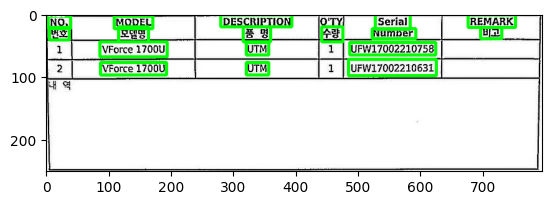

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/durian_dataset/table_image/905_1566_7514d469c3f52f078889b33ebad1e008_table.jpg"

reader = easyocr.Reader(['en']) # 인식 객체 생성
result = reader.readtext(path) # 인식 결과 저장

# 텍스트 영역 좌표 추출
boxes = []
for bbox in result: # Iterate directly over result
    boxes.append(bbox[0])

# 이미지 읽기
img = cv2.imread(path)

# 인식 박스 표시
for box in boxes:
    top_left = tuple(box[0])
    bottom_right = tuple(box[2])
    img = cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 3)

# 인식된 텍스트 표시
text = result[0][1]
top_left = tuple(result[0][0][0])
font = cv2.FONT_HERSHEY_SIMPLEX
img = cv2.putText(img, text, top_left, font, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

plt.imshow(img)
plt.show()

In [ ]:
# easyocr 사용하여 텍스트 인식
reader = easyocr.Reader(['en'])  # 사용할 언어 설정
easyocr_preds = reader.readtext(img)  # 이미지 데이터 직접 전달

# 인식된 텍스트를 문자열로 변환
recognized_texts = [prediction[1].strip() for prediction in easyocr_preds]

# 문자열로 결합
recognized_text_str = ' '.join(recognized_texts)

# 불필요한 공백 및 특수문자 제거
recognized_text_str = re.sub(r'[^\w\s\.]+', '', recognized_text_str)  # 특수 문자 제거
recognized_text_str = re.sub(r'\s+', ' ', recognized_text_str)  # 불필요한 공백 제거

print(recognized_text_str)

NO. MODEL DESCRIPTION Serial REMARK Mr 58 6 3 Mumper HlZ VForce 1700U UTM UFW1 7002210758 VForce 1700U UTM UFW17002210631


## Keras-OCR

In [ ]:
table_img = show_table(path)

Looking for /root/.keras-ocr/craft_mlt_25k.h5


Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.


Looking for /root/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 7s 7s/step


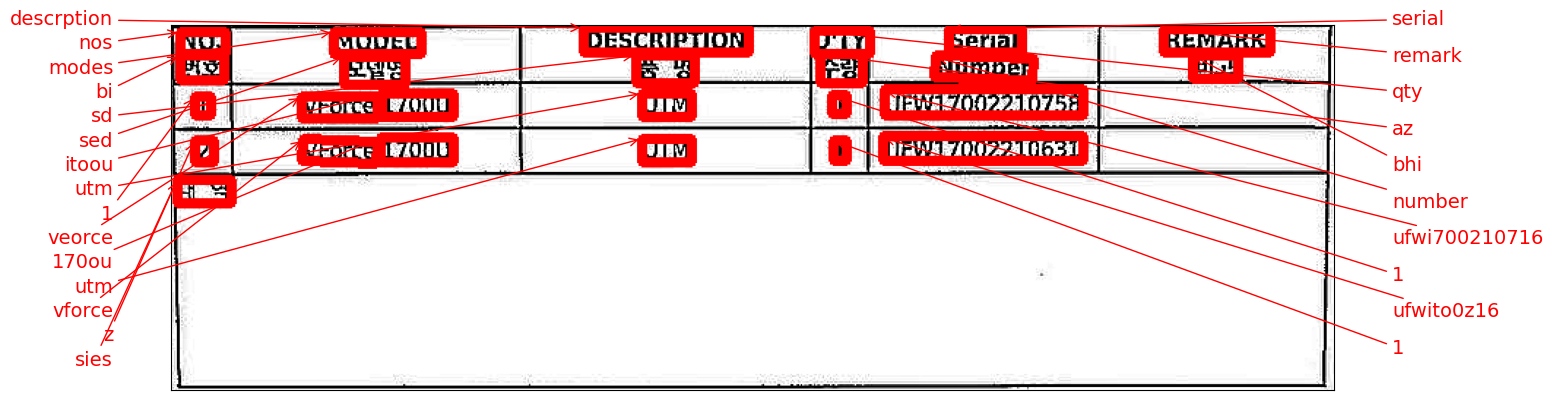

In [ ]:
table_img = cv2.cvtColor(table_img, cv2.COLOR_GRAY2BGR)
pipeline = keras_ocr.pipeline.Pipeline()

kerasocr_preds = pipeline.recognize([table_img])  # 인식할 이미지 리스트 전달

# 결과 시각화
fig, ax = plt.subplots(figsize=(15, 15))
keras_ocr.tools.drawAnnotations(image=table_img, predictions=kerasocr_preds[0], ax=ax)
plt.show()

In [ ]:
# 인식한 텍스트를 문자열로 변환
recognized_texts = []
for prediction in kerasocr_preds[0]:
    recognized_texts.append(prediction[0])  # prediction[0]는 인식된 텍스트

# 문자열로 결합
recognized_text_str = ' '.join(recognized_texts)
print(recognized_text_str)

descrption serial remark qty nos modes az bi sd number bhi sed ufwi700210716 itoou utm 1 1 veorce 170ou ufwito0z16 z vforce utm 1 sies


##Google Vision AI

In [ ]:
# pdf 혹은 이미지 경로
path = "/content/drive/MyDrive/Colab Notebooks/durian_dataset/table_image/905_1566_7514d469c3f52f078889b33ebad1e008_table.jpg"

In [ ]:
# 이미지 호출 함수
def load_image(path, extension_list=['png', 'jpeg', 'jpg', 'pdf']):
  extension = path.split('.')[-1]
  filename = path.split('/')[-1]  # error 표시용
  if extension not in extension_list:
    raise ValueError(f'Unsupported extension: {filename}')

  if extension in ['png', 'jpeg', 'jpg']:
    flag = cv2.IMREAD_COLOR
    img = cv2.imread(path, flag)
  elif extension == 'pdf':
    pdf_document = fitz.open(path)
    page = pdf_document.load_page(0)  # 첫 번째 페이지만 호출
    pix = page.get_pixmap()
    img = cv2.imdecode(np.frombuffer(pix.tobytes(), dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
  else:
    raise ValueError(f'Unsupported extension: {filename}')

  if img is None:
    raise Exception(f'Image call failed: {filename}')

  return img

In [ ]:
def detect_text(path):
    client = vision.ImageAnnotatorClient()

    # 이미지 처리만 할 경우
    # with open(path, "rb") as image_file:
    #     content = image_file.read()

    # pdf 처리만 할 경우
    content2 = load_image(path)
    # plt.imshow(cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE))
    # plt.title('base')
    # plt.axis('off')  # 축 제거
    # plt.show()
    content_bytes = cv2.imencode('.png', content2)[1].tobytes()
    # print(type(content_bytes))

    image = vision.Image(content=content_bytes)
    response = client.text_detection(image=image)
    texts = response.text_annotations
    return texts[0].description

In [ ]:
text = detect_text(path)
text.replace('\n', ' ')

"NO. 번호 MODEL 모델명 DESCRIPTION Q'TY Serial REMARK 품명 수량 Number 비고 1 VForce 1700U UTM 1 UFW17002210758 2 VForce 1700U UTM 1 UFW17002210631 내역"

# 추출한 텍스트 데이터 구조화 및 저장

In [ ]:
# 파일명(혹은 경로)에서 forcasting_seq 추출 함수
def forcasting_seq_extraction(string):
    last_part = string.split('/')[-1]# '/'로 split하여 마지막 값을 가져옴
    forcasting_seq = last_part.split('_')[1]# '_'로 split하여 두 번째 값을 가져옴
    return forcasting_seq

In [ ]:
# 추출한 데이터를 저장할 dataframe 구조 생성
doc_data = pd.DataFrame(columns=['forcasting_seq', 'text'])

In [ ]:
def findTargetPaths(dataInputPath):
    '''
    경로 내에서 특정 확장자를 가지는 파일의 경로를 추출하는 함수
    '''
    paths = [] # 타겟 파일의 전체 경로를 저장할 리스트
    extension_list=['png', 'jpeg', 'jpg', 'pdf']# 타겟 파일의 확장자

    try:
        for dirpath, dirnames, filenames in os.walk(dataInputPath): # 지정 경로 내의 하위 디렉토리 전체 순회
            for filename in filenames:
                if filename.split('.')[-1] in extension_list:
                    paths.append(os.path.join(dirpath, filename)) # 파일의 전체 경로를 문자열으로 paths list에 저장
                else:
                  pass
    except Exception as e:
                print(e)
    return paths

In [ ]:
dataInputPath = "./durian_dataset/table_image"
paths = findTargetPaths(dataInputPath)

# doc_data에 파일명에서 추출한 forcasting_seq와 Google Vision AI로 추출한 text 입력
for path in paths:
  # Google Vision으로 text 추출
  try:
    text = detect_text(path)
    text = text.replace('\n', ' ')
  except:
    text = np.NAN

  # forcasting_seq 추출
  try:
    forcasting_seq = int(forcasting_seq_extraction(path))
  except:
    forcasting_seq = np.NAN

  # 데이터 입력
  try:
    new_row = {'forcasting_seq': forcasting_seq, 'text': text}
    doc_data = pd.concat([doc_data, pd.DataFrame([new_row])], ignore_index=True)
  except Exception as e:
    print(e)

In [ ]:
# 추출 데이터 저장
# doc_data.to_excel('extract_GoogleVision_data.xlsx', index=False)

# 파일로 추출한 데이터 호출
doc_data_path = "./extract_GoogleVision_data.xlsx"
doc_data = pd.read_excel(doc_data_path)

In [ ]:
doc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   forcasting_seq  53 non-null     int64 
 1   text            52 non-null     object
dtypes: int64(1), object(1)
memory usage: 976.0+ bytes


In [ ]:
doc_data

,forcasting_seq,text
0,1437,NO. MODEL 번호 모델명 1 PEA-40A 2 3 4 5 6 7 내역 DESC...
1,1465,NO. 번호 1 2 3 4 5 B 7 내역 MODEL 모델명 Neobox MID43...
2,1430,NO. MODEL DESCRIPTION QTY 번호 모델명 품명 수량 1 Licen...
3,1464,NO. 번호 MODEL 모델명 Neobox MID43 1 2 3 4 5 B 7 내역...
4,1463,NO. 번호 1 2 3 4 5 B 7 내역 MODEL 모델명 Neobox M104 ...
5,1462,NO. 번호 MODEL 모델명 Neobox MID43 1 2 3 4 5 B 7 내역...
6,1441,NO. 번호 MODEL 모델명 DESCRIPTION QTY 품명 수량 1 BLUEM...
7,1439,NO. 번호 MODEL DESCRIPTION Q'TY Serial REMARK 모델...
8,1461,NO. 번호 1 2 3 4 5 B 7 내역 QTY 수량 1 Serial Number...
9,1451,NO. 번호 1 2 3 4 5 6 7 내역 MODEL 모델명 DESCRIPTION ...


# 추출한 데이터의 유사도 연산 비교
- fuzz
  문자열 간 유사도를 연산 라이브러리  
  Levenshtein 거리 알고리즘을 기반
  간단한 문자열 유사도 비교에 효과적이지만, 긴 텍스트나 복잡한 구조에서는 성능이 떨어짐

- Transformers
  Hugging Face에서 제공하는 라이브러리로, 자연어 처리(NLP) 모델을 사용하여 텍스트 분석 및 변환을 수행  
  매우 높은 정확도를 제공하지만, 설정과 사용이 비교적 복잡하고 더 많은 계산 자원이 필요

- difflib
  Python 표준 라이브러리의 일부로, 두 개의 시퀀스(주로 문자열)의 차이점을 비교하고 유사성을 계산하는 기능을 제공  


간단한 문자열 유사도 비교: fuzz (FuzzyWuzzy)  
고급 텍스트 분석: Transformers  
기본적인 문자열 비교: difflib  

제품정보.xlsx에서 데이터 대조에 필요한 데이터를 추출하여 info_data(dataframe) 저장  
info_data의 정보를 기반으로 추출한 텍스트의 정확도 검증

In [ ]:
# 제품정보.xlsx 파일에서 필요 데이터 추출
product_info_path = "./durian_dataset/제품정보.xlsx"
info_data = pd.read_excel(product_info_path)
info_data = info_data[['forcasting_seq', 'product_name', 'product_serial']]
info_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   forcasting_seq  122 non-null    int64 
 1   product_name    122 non-null    object
 2   product_serial  91 non-null     object
dtypes: int64(1), object(2)
memory usage: 3.0+ KB


In [ ]:
# 추출한 forcasting_seq와 text
df = doc_data.copy()
df.head()

,forcasting_seq,text
0,1437,NO. MODEL 번호 모델명 1 PEA-40A 2 3 4 5 6 7 내역 DESC...
1,1465,NO. 번호 1 2 3 4 5 B 7 내역 MODEL 모델명 Neobox MID43...
2,1430,NO. MODEL DESCRIPTION QTY 번호 모델명 품명 수량 1 Licen...
3,1464,NO. 번호 MODEL 모델명 Neobox MID43 1 2 3 4 5 B 7 내역...
4,1463,NO. 번호 1 2 3 4 5 B 7 내역 MODEL 모델명 Neobox M104 ...


In [ ]:
# 제품 정보의 데이터
info_data.head()

,forcasting_seq,product_name,product_serial
0,1221,WAPPLES-2600,W2600I-2230003
1,1358,BLUEMAX WIPS 1000,DSF22C12S14009
2,1358,BLUEMAX WIPS 602,JTM8WA1001961
3,1358,BLUEMAX WIPS 602,JTM8WA1001962
4,1358,BLUEMAX WIPS 602,JTM8WA1001963


## fuzz
- 문자열 간 유사성을 측정하기 위해 Levenshtein Distance(편집 거리)를 활용하는 라이브러리
- 문자열 유사도 분석을 신속하게 수행할 수 있어 빠른 프로토타이핑에 적합
-문맥적 유사도보다는 단순히 편집 거리에 기반하기 때문에 문맥적 의미를 파악하기 어려움

In [ ]:
# 결과 저장 리스트
names = []

# 추출한 데이터가 포함된 데이터프레임 순회
for idx, row in df.iterrows():
    forcasting_seq = row['forcasting_seq']
    text = row['text']
    if pd.isna(text): # Check if text is NaN
        names.append(np.NAN)
        continue # Skip to the next iteration if text is NaN

    # 해당 forcasting_seq의 product_name 리스트 추출
    matching_names = info_data[info_data['forcasting_seq'] == forcasting_seq]['product_name'].tolist()

    matched = False
    similarity_list = [] # 유사도를 넣어서 여기서 유사도가 가장 높은 name 하나만 반환
    for name in matching_names:
        # 유사도 계산
        similarity = fuzz.ratio(name, text)
        if similarity >= 30:
            similarity_list.append([similarity, name])
            matched = True # 하나라도 기준을 맞춘 name이 있을 경우
            break
        else:
            pass
    if len(similarity_list) >= 1:
        max_similarity = max(similarity_list, key=lambda x: x[0])
        names.append(max_similarity[1])
    else:
        names.append(np.NAN)
    if not matched: # 기준치 이상 값이 하나도 없을 경우
        pass

In [ ]:
match_data_fuzz = df.copy()
match_data_fuzz['predict_name'] = ''
match_data_fuzz['predict_serial'] = ''
try:
  if len(names) == len(match_data_fuzz):
      match_data_fuzz['predict_name'] = names
  else:
      raise
except Exception as e:
  print(e)

In [ ]:
serials = []

# match_data_fuzz['predict_name']의 각 값과 매칭되는 serial 찾기
for idx, predict_name in enumerate(match_data_fuzz['predict_name']):
    if pd.isna(predict_name):
        # predict_name이 NaN인 경우
        serials.append(np.nan)
    else:
        matched = False
        text = match_data_fuzz.loc[idx, 'text']  # 현재 인덱스의 match_data['text'] 값
        # info_data를 순회하며 product_name과 일치하는 product_serial 값을 찾음
        for _, row in info_data.iterrows():
            if row['product_name'] == predict_name:
                # Convert 'product_serial' to string before calculating similarity
                similarity = fuzz.ratio(str(row['product_serial']), text)
                if similarity >= 30:
                    serials.append(row['product_serial'])
                    matched = True
                    break
        if not matched:
            serials.append(np.nan)

In [ ]:
try:
  if len(serials) == len(match_data_fuzz):
      match_data_fuzz['predict_serial'] = serials
  else:
      raise
except Exception as e:
  print(e)

In [ ]:
# 결과 확인

# 제품정보에 있는 모델명을 추출한 경우
success = match_data_fuzz.dropna(subset=['predict_name']).shape[0]

# predict_name만 있고 predict_serial이 없는 경우
half_success = match_data_fuzz[match_data_fuzz['predict_name'].notna() & match_data_fuzz['predict_serial'].isna()].shape[0]

# predict_name과 predict_serial 둘 다 없는 경우
fail = match_data_fuzz.shape[0] - success

# 결과 출력
print("< fuzz >")
print("제품정보에 있는 모델명을 추출한 경우: ",f"{success*100/len(match_data_fuzz):.2f}%")
print("제품정보에 있는 predict_serial이 없는 경우: ",f"{half_success*100/len(match_data_fuzz):.2f}%")
print("제품정보에 있는 모델명을 추출 실패: ",f"{fail*100/len(match_data_fuzz):.2f}%")

< fuzz >
제품정보에 있는 모델명을 추출한 경우:  26.42%
제품정보에 있는 predict_serial이 없는 경우:  26.42%
제품정보에 있는 모델명을 추출 실패:  73.58%


In [ ]:
match_data_fuzz

,forcasting_seq,text,predict_name,predict_serial
0,1437,NO.\nMODEL\n번호\n모델명\n1\nPEA-40A\n2\n3\n4\n5\n6...,NaN,NaN
1,1465,NO.\n번호\n1\n2\n3\n4\n5\nB\n7\n내역\nMODEL\n모델명\n...,NaN,NaN
2,1430,NO.\nMODEL\nDESCRIPTION\nQTY\n번호\n모델명\n품명\n수량\...,NaN,NaN
3,1464,NO.\n번호\nMODEL\n모델명\nNeobox MID43\n1\n2\n3\n4\...,NaN,NaN
4,1463,NO.\n번호\n1\n2\n3\n4\n5\nB\n7\n내역\nMODEL\n모델명\n...,NaN,NaN
5,1462,NO.\n번호\nMODEL\n모델명\nNeobox MID43\n1\n2\n3\n4\...,NaN,NaN
6,1441,NO.\n번호\nMODEL\n모델명\nDESCRIPTION\nQTY\n품명\n수량\...,NaN,NaN
7,1439,NO.\n번호\nMODEL\nDESCRIPTION\nQ'TY\nSerial\nREM...,GATEONE Z(AM) Node LIcense,NaN
8,1461,NO.\n번호\n1\n2\n3\n4\n5\nB\n7\n내역\nQTY\n수량\n1\n...,NaN,NaN
9,1451,NO.\n번호\n1\n2\n3\n4\n5\n6\n7\n내역\nMODEL\n모델명\n...,NaN,NaN


## Transformers
: Sentence Embeddings (BERT, Sentence-BERT)
- 문맥과 의미를 고려한 고급 NLP 모델로, 언어의 복잡한 패턴을 이해
- 입력된 텍스트를 토큰화하고, 각 토큰의 임베딩을 계산
- 문맥을 이해해야 하는 자연어 처리(NLP) 작업에 적합 (예: 텍스트 분류, 질의응답, 텍스트 생성 등
- 단어의 의미적 유사도를 평가할 때 유용

In [ ]:
# 1st.ver 추출된 단어와 유사도 값 반환

# 코사인 유사도 계산 함수
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# 입력 문장과 대상 단어 설정
sentence = "NO. 번호 MODEL 모델명 Neobox MID43 1 2 3 4 5 B 7 내역 DESCRIPTION QTY Serial REMARK 품명 수량 Number 비고 UTM 33"
target_word = "UTM"

# BERT 모델과 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

# 문장을 단어 단위로 분리
words = sentence.split()

# 대상 단어의 토큰 ID 및 임베딩 추출
target_inputs = tokenizer(target_word, return_tensors='pt')
with torch.no_grad():
    target_outputs = model(**target_inputs)
    target_embedding = target_outputs.last_hidden_state[:, 0, :].squeeze(0)

# 문장 내 각 단어와 대상 단어의 유사도 계산
similarities = []
for word in words:
    word_inputs = tokenizer(word, return_tensors='pt')
    with torch.no_grad():
        word_outputs = model(**word_inputs)
        word_embedding = word_outputs.last_hidden_state[:, 0, :].squeeze(0)
    similarity = cosine_similarity(word_embedding.numpy(), target_embedding.numpy())
    similarities.append([word, similarity])

# 유사도 기준으로 내림차순 정렬
similarities.sort(key=lambda x: x[1], reverse=True)

# # 상위 5개 유사 단어 출력
# for word, similarity in similarities[:5]:
#     print(f"Word: {word}, Cosine similarity: {similarity}")

# 유사도가 가장 높은 단어 및 유사도 출력
wordAbs = similarities[0][0]
similarityAbs = similarities[0][1]

print(similarities[0]) # 전체 출력: 리스트
print(wordAbs, similarityAbs) # 개별 출력

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

['UTM', 1.0]
UTM 1.0


In [ ]:
# 2nd.ver 유사도 값 입력시 해당 유사도 값 이상에 해당하는 단어 반환
def find_similar_word_in_sentence(sentence, target_word, threshold=0.7):
    """
    주어진 문장에서 유사한 단어를 찾아 반환합니다.

    Args:
    - sentence (str): 비교할 문장
    - target_word (str): 찾고자 하는 목표 단어
    - threshold (float): 유사도 임계값 (기본값: 0.7)

    Returns:
    - similar_word (str): 유사한 단어 (목표 단어와 유사도가 임계값 이상인 경우)
      유사한 단어가 없는 경우 None을 반환합니다.
    """

    similar_word = None
    max_ratio = 0

    # BERT 모델과 토크나이저 로드
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    model = BertModel.from_pretrained('bert-base-multilingual-cased')

    # 문장을 단어 단위로 분리
    words = sentence.split()

    # 대상 단어의 토큰 ID 및 임베딩 추출
    target_inputs = tokenizer(target_word, return_tensors='pt')
    with torch.no_grad():
        target_outputs = model(**target_inputs)
        target_embedding = target_outputs.last_hidden_state[:, 0, :].squeeze(0)

    # 코사인 유사도 계산 함수
    def cosine_similarity(v1, v2):
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

    # 문장 내 각 단어와 대상 단어의 유사도 계산
    for word in words:
        word_inputs = tokenizer(word, return_tensors='pt')
        with torch.no_grad():
            word_outputs = model(**word_inputs)
            word_embedding = word_outputs.last_hidden_state[:, 0, :].squeeze(0)
        similarity = cosine_similarity(word_embedding.numpy(), target_embedding.numpy())
        if similarity > max_ratio:
            max_ratio = similarity
            similar_word = word

    if max_ratio >= threshold:
      return similar_word
    else:
      return None

# 예시 문장
sentence = "NO. 번호 MODEL 모델명 Neobox MID43 1 2 3 4 5 B 7 내역 DESCRIPTION QTY Serial REMARK 품명 수량 Number 비고 UTM 33"
target_word = "UTM"

# 유사한 단어 찾기
similar_word = find_similar_word_in_sentence(sentence, target_word)
if similar_word:
    print(f"Found similar word: {similar_word}")
else:
    print("No similar word found")

Found similar word: UTM


In [ ]:
# 코사인 유사도 계산 함수
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# 입력 문장과 대상 단어를 인자로 받아 유사도가 가장 높은 단어와 유사도 값을 반환하는 함수
def find_trans_similarity(sentence, target_word):
    # BERT 모델과 토크나이저 로드
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    model = BertModel.from_pretrained('bert-base-multilingual-cased')

    # 문장을 단어 단위로 분리
    words = sentence.split()

    # 대상 단어의 토큰 ID 및 임베딩 추출
    target_inputs = tokenizer(target_word, return_tensors='pt')
    with torch.no_grad():
        target_outputs = model(**target_inputs)
        target_embedding = target_outputs.last_hidden_state[:, 0, :].squeeze(0)

    # 문장 내 각 단어와 대상 단어의 유사도 계산
    similarities = []
    for word in words:
        word_inputs = tokenizer(word, return_tensors='pt')
        with torch.no_grad():
            word_outputs = model(**word_inputs)
            word_embedding = word_outputs.last_hidden_state[:, 0, :].squeeze(0)
        similarity = cosine_similarity(word_embedding.numpy(), target_embedding.numpy())
        similarities.append([word, similarity])

    # 유사도 기준으로 내림차순 정렬
    similarities.sort(key=lambda x: x[1], reverse=True)

    # 유사도가 가장 높은 단어 및 유사도 값 반환
    most_similar_word = similarities[0][0]
    highest_similarity = similarities[0][1]

    return highest_similarity

In [ ]:
# 결과 저장 리스트
names = []

for idx, row in df.iterrows():
    forcasting_seq = row['forcasting_seq']
    text = row['text']
    if pd.isna(text): # Check if text is NaN
        names.append(np.NAN)
        continue

    matching_names = info_data[info_data['forcasting_seq'] == forcasting_seq]['product_name'].tolist()

    matched = False
    similarity_list = []
    for name in matching_names:
        similarity = find_trans_similarity(text, name) * 100
        if similarity >= 30:
            similarity_list.append([similarity, name])
            # print(similarity)
            matched = True
            break
        else:
            pass
    if len(similarity_list) >= 1:
        max_similarity = max(similarity_list, key=lambda x: x[0])
        names.append(max_similarity[1])
    else:
        names.append(np.NAN)
    if not matched:
        pass

In [ ]:
match_data_trans = df.copy()
match_data_trans['predict_name'] = ''
match_data_trans['predict_serial'] = ''
try:
  if len(names) == len(match_data_trans):
      match_data_trans['predict_name'] = names
  else:
      raise
except Exception as e:
  print(e)

In [ ]:
serials = []

for idx, predict_name in enumerate(match_data_trans['predict_name']):
    if pd.isna(predict_name):
        serials.append(np.nan)
    else:
        matched = False
        text = match_data_trans.loc[idx, 'text']
        for _, row in info_data.iterrows():
            if row['product_name'] == predict_name:
                similarity = find_trans_similarity(text, str(row['product_serial'])) * 100
                if similarity >= 30:
                    serials.append(row['product_serial'])
                    matched = True
                    break
        if not matched:
            serials.append(np.nan)

In [ ]:
try:
  if len(serials) == len(match_data_trans):
      match_data_trans['predict_serial'] = serials
  else:
      raise
except Exception as e:
  print(e)

In [ ]:
# 결과 확인

# 제품정보에 있는 모델명을 추출한 경우
success = match_data_trans.dropna(subset=['predict_name']).shape[0]

# predict_name만 있고 predict_serial이 없는 경우
half_success = match_data_trans[match_data_trans['predict_name'].notna() & match_data_trans['predict_serial'].isna()].shape[0]

# predict_name과 predict_serial 둘 다 없는 경우
fail = match_data_trans.shape[0] - success

# 결과 출력
print("< transformers >")
print("제품정보에 있는 모델명을 추출한 경우: ",f"{success*100/len(match_data_trans):.2f}%")
print("제품정보에 있는 predict_serial이 없는 경우: ",f"{half_success*100/len(match_data_trans):.2f}%")
print("제품정보에 있는 모델명을 추출 실패: ",f"{fail*100/len(match_data_trans):.2f}%")

< transformers >
제품정보에 있는 모델명을 추출한 경우:  98.11%
제품정보에 있는 predict_serial이 없는 경우:  39.62%
제품정보에 있는 모델명을 추출 실패:  1.89%


In [ ]:
match_data_trans

,forcasting_seq,text,predict_name,predict_serial
0,1437,NO. MODEL 번호 모델명 1 PEA-40A 2 3 4 5 6 7 내역 DESC...,PEA-40A,N0040A002928
1,1465,NO. 번호 1 2 3 4 5 B 7 내역 MODEL 모델명 Neobox MID43...,Neobox M104a,NaN
2,1430,NO. MODEL DESCRIPTION QTY 번호 모델명 품명 수량 1 Licen...,GATEONE Z(AM) Node LIcense,NaN
3,1464,NO. 번호 MODEL 모델명 Neobox MID43 1 2 3 4 5 B 7 내역...,Neobox M104a,NaN
4,1463,NO. 번호 1 2 3 4 5 B 7 내역 MODEL 모델명 Neobox M104 ...,Neobox M104a,NaN
5,1462,NO. 번호 MODEL 모델명 Neobox MID43 1 2 3 4 5 B 7 내역...,Neobox M104a,NaN
6,1441,NO. 번호 MODEL 모델명 DESCRIPTION QTY 품명 수량 1 BLUEM...,BLUEMAX NGF 100 BASIC,JTN4UA0060190
7,1439,NO. 번호 MODEL DESCRIPTION Q'TY Serial REMARK 모델...,GATEONE Z(AM) Node LIcense,NaN
8,1461,NO. 번호 1 2 3 4 5 B 7 내역 QTY 수량 1 Serial Number...,PEA-40A,N0040A002928
9,1451,NO. 번호 1 2 3 4 5 6 7 내역 MODEL 모델명 DESCRIPTION ...,BLUEMAX IPS 2000,JTN6IB3010002


## difflib
- 단순한 문자열 비교 알고리즘으로, 문맥을 고려하지 않고 문자 일치 여부에 따라 유사도를 계산
- 두 문자열 간의 유사도를 편집 거리(Edit Distance) 기반으로 계산
- 단순한 문자열 매칭, 텍스트 비교, 차이점 찾기 등 단순한 문자열 조작 작업에 적합
- 텍스트의 단순한 일치 여부를 평가할 때 유용

In [ ]:
# 1st.ver 추출된 단어와 유사도 값 반환

# 예시 문장
sentence = "NO. 번호 MODEL 모델명 Neobox MID43 1 2 3 4 5 B 7 내역 DESCRIPTION QTY Serial REMARK 품명 수량 Number 비고 UTM 33"
target_word = "UTM"

words = sentence.split()  # 문장을 단어로 분할

# 유사도가 가장 높은 단어 및 유사도 출력
similarities = []
for word in words:
    ratio = SequenceMatcher(None, target_word, word).ratio()
    similarities.append([word, ratio])

# 유사도 기준으로 내림차순 정렬
similarities.sort(key=lambda x: x[1], reverse=True)

# # 상위 5개 유사 단어 출력
# for word, similarity in similarities[:5]:
#     print(f"Word: {word}, Cosine similarity: {similarity}")

# 유사도가 가장 높은 단어 및 유사도 출력
wordAbs = similarities[0][0]
similarityAbs = similarities[0][1]

print(similarities[0]) # 전체 출력: 리스트
print(wordAbs, similarityAbs) # 개별 출력

['UTM', 1.0]
UTM 1.0


In [ ]:
# 2nd.ver 유사도 값 입력시 해당 유사도 값 이상에 해당하는 단어 반환

def find_similar_word_in_sentence(sentence, target_word, threshold=0.7):
    """
    주어진 문장에서 유사한 단어를 찾아 반환합니다.

    Args:
    - sentence (str): 비교할 문장
    - target_word (str): 찾고자 하는 목표 단어
    - threshold (float): 유사도 임계값 (기본값: 0.7)

    Returns:
    - similar_word (str): 유사한 단어 (목표 단어와 유사도가 임계값 이상인 경우)
      유사한 단어가 없는 경우 None을 반환합니다.
    """

    similar_word = None
    max_ratio = 0

    words = sentence.split()  # 문장을 단어로 분할

    for word in words:
        ratio = SequenceMatcher(None, target_word, word).ratio()
        if ratio > max_ratio:
            max_ratio = ratio
            similar_word = word

    if max_ratio >= threshold:
        return similar_word
    else:
        return None

# 예시 문장
sentence = "NO. 번호 MODEL 모델명 Neobox MID43 1 2 3 4 5 B 7 내역 DESCRIPTION QTY Serial REMARK 품명 수량 Number 비고 UTM 33"
target_word = "UTM"

# 유사한 단어 찾기
similar_word = find_similar_word_in_sentence(sentence, target_word)
if similar_word:
    print(f"Found similar word: {similar_word}")
else:
    print("No similar word found")

Found similar word: UTM


In [ ]:
def find_difflib_similarity(sentence, target_word):
    words = sentence.split()  # 문장을 단어로 분할

    # 유사도가 가장 높은 단어 및 유사도 출력
    similarities = []
    for word in words:
        ratio = SequenceMatcher(None, target_word, word).ratio()
        similarities.append([word, ratio])

    # 유사도 기준으로 내림차순 정렬
    similarities.sort(key=lambda x: x[1], reverse=True)

    # 유사도가 가장 높은 단어 및 유사도 추출
    wordAbs = similarities[0][0]
    similarityAbs = similarities[0][1]

    return similarityAbs

In [ ]:
# 결과 저장 리스트
names = []

for idx, row in df.iterrows():
    forcasting_seq = row['forcasting_seq']
    text = row['text']
    if pd.isna(text): # Check if text is NaN
        names.append(np.NAN)
        continue

    matching_names = info_data[info_data['forcasting_seq'] == forcasting_seq]['product_name'].tolist()

    matched = False
    similarity_list = []
    for name in matching_names:
        similarity = find_difflib_similarity(text, name) * 100
        if similarity >= 30:
            similarity_list.append([similarity, name])
            # print(similarity)
            matched = True
            break
        else:
            pass
    if len(similarity_list) >= 1:
        max_similarity = max(similarity_list, key=lambda x: x[0])
        names.append(max_similarity[1])
    else:
        names.append(np.NAN)
    if not matched:
        pass

In [ ]:
match_data_difflib = df.copy()
match_data_difflib['predict_name'] = ''
match_data_difflib['predict_serial'] = ''
try:
  if len(names) == len(match_data_difflib):
      match_data_difflib['predict_name'] = names
  else:
      raise
except Exception as e:
  print(e)

In [ ]:
serials = []

for idx, predict_name in enumerate(match_data_difflib['predict_name']):
    if pd.isna(predict_name):
        serials.append(np.nan)
    else:
        matched = False
        text = match_data_difflib.loc[idx, 'text']
        for _, row in info_data.iterrows():
            if row['product_name'] == predict_name:
                similarity = find_difflib_similarity(text, str(row['product_serial'])) * 100
                if similarity >= 30:
                    serials.append(row['product_serial'])
                    matched = True
                    break
        if not matched:
            serials.append(np.nan)

In [ ]:
try:
  if len(serials) == len(match_data_difflib):
      match_data_difflib['predict_serial'] = serials
  else:
      raise
except Exception as e:
  print(e)

In [ ]:
# 결과 확인

# 제품정보에 있는 모델명을 추출한 경우
success = match_data_difflib.dropna(subset=['predict_name']).shape[0]

# predict_name만 있고 predict_serial이 없는 경우
half_success = match_data_difflib[match_data_difflib['predict_name'].notna() & match_data_difflib['predict_serial'].isna()].shape[0]

# predict_name과 predict_serial 둘 다 없는 경우
fail = match_data_difflib.shape[0] - success

# 결과 출력
print("< difflib >")
print("제품정보에 있는 모델명을 추출한 경우: ",f"{success*100/len(match_data_difflib):.2f}%")
print("제품정보에 있는 predict_serial이 없는 경우: ",f"{half_success*100/len(match_data_difflib):.2f}%")
print("제품정보에 있는 모델명을 추출 실패: ",f"{fail*100/len(match_data_difflib):.2f}%")

< difflib >
제품정보에 있는 모델명을 추출한 경우:  98.11%
제품정보에 있는 predict_serial이 없는 경우:  43.40%
제품정보에 있는 모델명을 추출 실패:  1.89%


In [ ]:
match_data_difflib

,forcasting_seq,text,predict_name,predict_serial
0,1437,NO. MODEL 번호 모델명 1 PEA-40A 2 3 4 5 6 7 내역 DESC...,PEA-40A,N0040A002928
1,1465,NO. 번호 1 2 3 4 5 B 7 내역 MODEL 모델명 Neobox MID43...,Neobox M104a,NaN
2,1430,NO. MODEL DESCRIPTION QTY 번호 모델명 품명 수량 1 Licen...,GATEONE Z(AM) Node LIcense,NaN
3,1464,NO. 번호 MODEL 모델명 Neobox MID43 1 2 3 4 5 B 7 내역...,Neobox M104a,NaN
4,1463,NO. 번호 1 2 3 4 5 B 7 내역 MODEL 모델명 Neobox M104 ...,Neobox M104a,NaN
5,1462,NO. 번호 MODEL 모델명 Neobox MID43 1 2 3 4 5 B 7 내역...,Neobox M104a,NaN
6,1441,NO. 번호 MODEL 모델명 DESCRIPTION QTY 품명 수량 1 BLUEM...,BLUEMAX NGF 100 BASIC,JTN4UA0060190
7,1439,NO. 번호 MODEL DESCRIPTION Q'TY Serial REMARK 모델...,GATEONE Z(AM) Node LIcense,NaN
8,1461,NO. 번호 1 2 3 4 5 B 7 내역 QTY 수량 1 Serial Number...,PEA-40A,N0040A002928
9,1451,NO. 번호 1 2 3 4 5 6 7 내역 MODEL 모델명 DESCRIPTION ...,BLUEMAX IPS 2000,JTN6IB3010002
